# Solar Power Generation


## Preparation


In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error


for dirname, _, filenames in os.walk("./data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Plant_2_Generation_Data.csv
./data/Plant_1_Generation_Data.csv
./data/Plant_2_Weather_Sensor_Data.csv
./data/Plant_1_Weather_Sensor_Data.csv


In [432]:
# Data Loading
generation_data_plant_1 = pd.read_csv("./data/Plant_1_Generation_Data.csv")
weather_data_plant_1 = pd.read_csv("./data/Plant_1_Weather_Sensor_Data.csv")
generation_data_plant_2 = pd.read_csv("./data/Plant_2_Generation_Data.csv")
weather_data_plant_2 = pd.read_csv("./data/Plant_2_Weather_Sensor_Data.csv")

## Data Exploration


### Data format showing


In [433]:
# Convert DATE_TIME columns to datetime
generation_data_plant_1["DATE_TIME"] = pd.to_datetime(
    generation_data_plant_1["DATE_TIME"], format="%d-%m-%Y %M:%S"
)
weather_data_plant_1["DATE_TIME"] = pd.to_datetime(
    weather_data_plant_1["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)
generation_data_plant_2["DATE_TIME"] = pd.to_datetime(
    generation_data_plant_2["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)
weather_data_plant_2["DATE_TIME"] = pd.to_datetime(
    weather_data_plant_2["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)

# Display the first few rows of each dataset to understand their structure
# Display the first few rows of each dataset to understand their structure
generation_data_plant_1_head = generation_data_plant_1.head()
weather_data_plant_1_head = weather_data_plant_1.head()
generation_data_plant_2_head = generation_data_plant_2.head()
weather_data_plant_2_head = weather_data_plant_2.head()

generation_data_plant_1_head, weather_data_plant_1_head
generation_data_plant_2_head, weather_data_plant_2_head

(   DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
 0 2020-05-15   4136001  4UPUqMRk7TRMgml       0.0       0.0  9425.000000   
 1 2020-05-15   4136001  81aHJ1q11NBPMrL       0.0       0.0     0.000000   
 2 2020-05-15   4136001  9kRcWv60rDACzjR       0.0       0.0  3075.333333   
 3 2020-05-15   4136001  Et9kgGMDl729KT4       0.0       0.0   269.933333   
 4 2020-05-15   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0  3177.000000   
 
     TOTAL_YIELD  
 0  2.429011e+06  
 1  1.215279e+09  
 2  2.247720e+09  
 3  1.704250e+06  
 4  1.994153e+07  ,
             DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
 0 2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
 1 2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
 2 2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
 3 2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0            26.500589   
 4 2020-05-15 01:00:00   4136001  iq8k7ZNt4Mwm3w0  

## Data processing and merging


In [434]:
# Checking for missing values in Plant 2 datasets
generation_data_plant_1_missing_values = generation_data_plant_1.isnull().sum()
weather_data_plant_1_missing_values = weather_data_plant_1.isnull().sum()
generation_data_plant_2_missing_values = generation_data_plant_2.isnull().sum()
weather_data_plant_2_missing_values = weather_data_plant_2.isnull().sum()

# Combining Plant 1 and Plant 2 data for a comprehensive dataset
# Since we want to perform analysis on daily data, we will aggregate data by day and merge with weather data accordingly

# Aggregating Plant 2 data to daily for generation and average for weather
generation_data_plant_1 = generation_data_plant_1.resample("1H", on="DATE_TIME").sum(
    numeric_only=True
)
weather_data_plant_1 = weather_data_plant_1.resample("1H", on="DATE_TIME").mean(
    numeric_only=True
)

# Merging the daily dataframes for Plant 1 on DATE_TIME for a combined analysis
data_merged_plant_1 = pd.merge(
    generation_data_plant_1,
    weather_data_plant_1,
    left_index=True,
    right_index=True,
    how="inner",
).dropna()

generation_data_plant_2 = generation_data_plant_2.resample("1H", on="DATE_TIME").sum(
    numeric_only=True
)
weather_data_plant_2 = weather_data_plant_2.resample("1H", on="DATE_TIME").mean(
    numeric_only=True
)

# Merging the daily dataframes for Plant 2 on DATE_TIME for a combined analysis
data_merged_plant_2 = pd.merge(
    generation_data_plant_2,
    weather_data_plant_2,
    left_index=True,
    right_index=True,
    how="inner",
).dropna()

# Now, we need to combine the daily data from both plants for a comprehensive analysis
# We will append Plant 2 data to Plant 1 data
data_combined = pd.concat([data_merged_plant_1, data_merged_plant_2], axis=0)

# Checking the structure of the combined data
data_combined_structure = data_combined.describe(include="all")

data_combined_structure

,PLANT_ID_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,1.594000e+03,1.594000e+03,1594.000000,1.594000e+03,1.594000e+03,1.594000e+03,1594.000000,1594.000000,1594.000000
mean,3.490583e+08,1.426404e+05,23171.721508,2.779471e+05,2.827851e+10,4.135513e+06,26.848134,31.988398,0.231347
std,1.184478e+09,9.167671e+05,90571.556102,9.645925e+05,2.726879e+10,5.000148e+02,3.926100,11.721453,0.301116
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.135001e+06,20.677156,18.292424,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.135001e+06,23.663056,22.451396,0.000000
50%,2.977921e+08,0.000000e+00,0.000000,1.201453e+04,4.209510e+10,4.136001e+06,25.990242,26.745125,0.030904
75%,3.639681e+08,7.734949e+03,7524.033095,3.352716e+05,5.675884e+10,4.136001e+06,29.338567,41.424549,0.461602
max,8.733122e+09,7.898965e+06,771576.161312,9.053215e+06,5.677631e+10,4.136001e+06,38.660055,63.042589,1.011703


## Data plotting


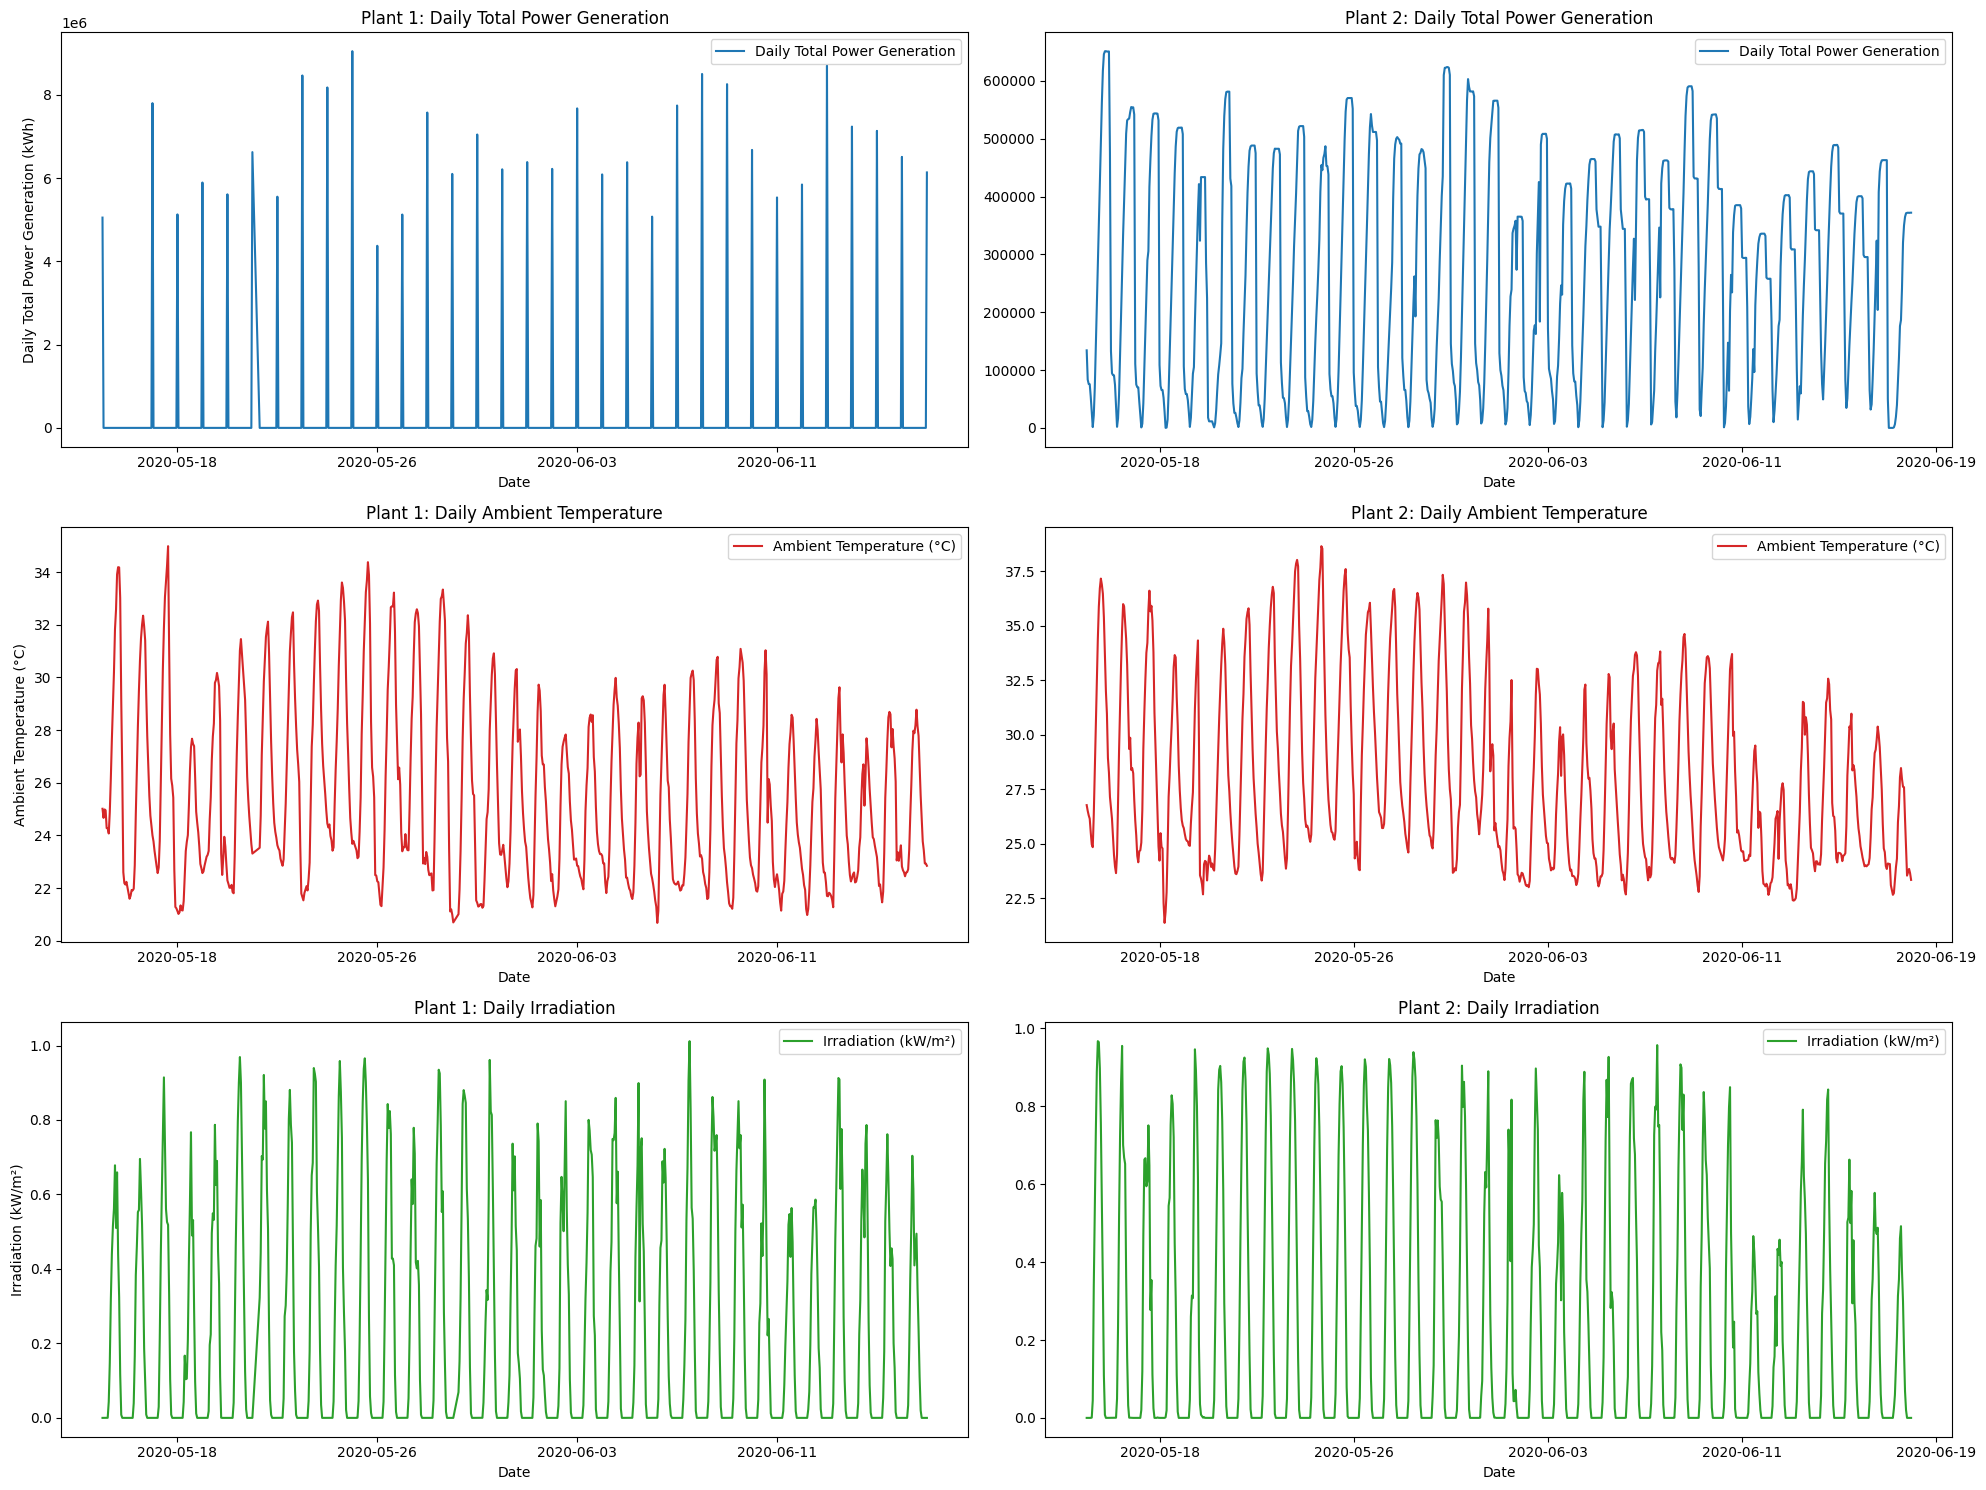

In [435]:
# Adjusting the layout to display Plant 1 and Plant 2 side by side for comparison

# Setting up the plot area for side-by-side comparison
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Plant 1 Daily Total Power Generation
axs[0, 0].plot(
    data_merged_plant_1.index,
    data_merged_plant_1["DAILY_YIELD"],
    color="tab:blue",
    label="Daily Total Power Generation",
)
axs[0, 0].set_title("Plant 1: Daily Total Power Generation")
axs[0, 0].set_ylabel("Daily Total Power Generation (kWh)")
axs[0, 0].legend()

# Plant 2 Daily Total Power Generation
axs[0, 1].plot(
    data_merged_plant_2.index,
    data_merged_plant_2["DAILY_YIELD"],
    color="tab:blue",
    label="Daily Total Power Generation",
)
axs[0, 1].set_title("Plant 2: Daily Total Power Generation")
axs[0, 1].legend()

# Plant 1 Ambient Temperature
axs[1, 0].plot(
    data_merged_plant_1.index,
    data_merged_plant_1["AMBIENT_TEMPERATURE"],
    color="tab:red",
    label="Ambient Temperature (°C)",
)
axs[1, 0].set_title("Plant 1: Daily Ambient Temperature")
axs[1, 0].set_ylabel("Ambient Temperature (°C)")
axs[1, 0].legend()

# Plant 2 Ambient Temperature
axs[1, 1].plot(
    data_merged_plant_2.index,
    data_merged_plant_2["AMBIENT_TEMPERATURE"],
    color="tab:red",
    label="Ambient Temperature (°C)",
)
axs[1, 1].set_title("Plant 2: Daily Ambient Temperature")
axs[1, 1].legend()

# Plant 1 Irradiation
axs[2, 0].plot(
    data_merged_plant_1.index,
    data_merged_plant_1["IRRADIATION"],
    color="tab:green",
    label="Irradiation (kW/m²)",
)
axs[2, 0].set_title("Plant 1: Daily Irradiation")
axs[2, 0].set_ylabel("Irradiation (kW/m²)")
axs[2, 0].legend()

# Plant 2 Irradiation
axs[2, 1].plot(
    data_merged_plant_2.index,
    data_merged_plant_2["IRRADIATION"],
    color="tab:green",
    label="Irradiation (kW/m²)",
)
axs[2, 1].set_title("Plant 2: Daily Irradiation")
axs[2, 1].legend()

# Setting up the x-axis labels
for ax in axs.flat:
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(
        plt.MaxNLocator(6)
    )  # Limit the number of x-axis labels to make them readable

plt.tight_layout()
plt.show()

                     DAILY_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
DAILY_YIELD             1.000000            -0.064364           -0.121173   
AMBIENT_TEMPERATURE    -0.064364             1.000000            0.821044   
MODULE_TEMPERATURE     -0.121173             0.821044            1.000000   
IRRADIATION            -0.125060             0.663252            0.959135   

                     IRRADIATION  
DAILY_YIELD            -0.125060  
AMBIENT_TEMPERATURE     0.663252  
MODULE_TEMPERATURE      0.959135  
IRRADIATION             1.000000  


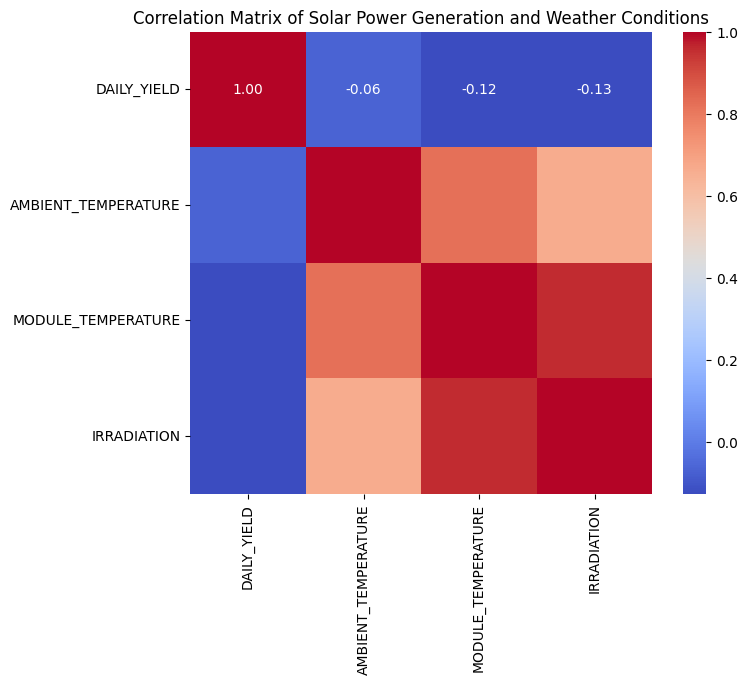

In [436]:
# Calculating the correlation matrix for the combined data of Plant 1 and Plant 2

# Selecting relevant columns for correlation analysis
relevant_columns = [
    "DAILY_YIELD",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "IRRADIATION",
]
correlation_matrix = data_combined[relevant_columns].corr()

print(correlation_matrix)

# Visualizing the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Solar Power Generation and Weather Conditions")
plt.show()

## Prediction


In [437]:
# Preparing features and target variable
features = data_combined[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
target = data_combined["DAILY_YIELD"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [438]:
# SVM Model Training
svm_model = SVR(kernel="rbf")
svm_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_svm = svm_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
r2_svm = r2_score(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)

r2_svm, mse_svm

(-0.06832885513452625, 523071871022.2405)

In [439]:
# GBDT Model Training
gbdt_model = GradientBoostingRegressor()
gbdt_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_gbdt = gbdt_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
r2_gbdt = r2_score(y_test, y_pred_gbdt)
mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)

r2_gbdt, mse_gbdt

(-0.32181390794881204, 647182438863.3047)

In [440]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim

# 转换数据为torch张量
X_train_torch = torch.tensor(X_train_scaled.astype(np.float32))
y_train_torch = torch.tensor(y_train.values.astype(np.float32))
X_test_torch = torch.tensor(X_test_scaled.astype(np.float32))
y_test_torch = torch.tensor(y_test.values.astype(np.float32))

# 创建TensorDataset和DataLoader
train_data = TensorDataset(X_train_torch, y_train_torch)
test_data = TensorDataset(X_test_torch, y_test_torch)

batch_size = 64  # 可以根据需要调整
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 64)  # 输入特征数为3，第一个隐藏层有64个节点
        self.fc2 = nn.Linear(64, 64)  # 第二个隐藏层
        self.fc3 = nn.Linear(64, 1)  # 输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
criterion = nn.MSELoss()  # 均方误差损失
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()  # 清零梯度
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

model.eval()  # 设置为评估模式
with torch.no_grad():  # 不计算梯度
    predictions = []
    for data in test_loader:
        output = model(data[0])
        predictions.append(output)
    # 计算预测值与真实值之间的MSE等指标

Epoch 1, Loss: 58944069632.0
Epoch 2, Loss: 2034987565056.0
Epoch 3, Loss: 3056348168192.0
Epoch 4, Loss: 2063821832192.0
Epoch 5, Loss: 1795796238336.0
Epoch 6, Loss: 677100716032.0
Epoch 7, Loss: 1704390426624.0
Epoch 8, Loss: 1402391625728.0
Epoch 9, Loss: 63737401344.0
Epoch 10, Loss: 3166478270464.0
Epoch 11, Loss: 1031062290432.0
Epoch 12, Loss: 2352336601088.0
Epoch 13, Loss: 926034427904.0
Epoch 14, Loss: 1254657753088.0
Epoch 15, Loss: 1041109417984.0
Epoch 16, Loss: 1722546782208.0
Epoch 17, Loss: 62916292608.0
Epoch 18, Loss: 1735506001920.0
Epoch 19, Loss: 47743721472.0
Epoch 20, Loss: 1120484851712.0
Epoch 21, Loss: 663454941184.0
Epoch 22, Loss: 523797495808.0
Epoch 23, Loss: 804607492096.0
Epoch 24, Loss: 62174015488.0
Epoch 25, Loss: 1600264470528.0
Epoch 26, Loss: 57954938880.0
Epoch 27, Loss: 1770315317248.0
Epoch 28, Loss: 741585125376.0
Epoch 29, Loss: 787492503552.0
Epoch 30, Loss: 598470361088.0
Epoch 31, Loss: 60307378176.0
Epoch 32, Loss: 1412935450624.0
Epoch 3